In [52]:
import operator 
from typing import List, TypedDict, Annotated 
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage 
from langchain_groq import ChatGroq 
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv 
import json 
import os
import ast

In [53]:
load_dotenv()

True

In [54]:
class LongTermMemory:
    def __init__(self, filepath = "agent_memory.json"):
        self.filepath = filepath
        if not os.path.exists(filepath):
            with open(filepath, "w", encoding = 'utf-8') as f:
                json.dump([], f)

    def load_lessons(self):
        """خواندن تمام درس های ذخیره شده"""
        with open(self.filepath, "r", encoding = 'utf-8') as f:
            return json.load(f)
        
    def save_lesson(self, lesson):
        """ذخیره یک درس جدید و مهم"""
        lessons = self.load_lessons()
        if lesson not in lessons:
            lessons.append(lesson)
            with open(self.filepath, "w", encoding = 'utf-8') as f:
                json.dump(lessons, f, ensure_ascii = False, indent = 2)
            print(f"درس جدید در حافظه بلند مدت ذخیره شد: {lesson}")

In [55]:
memory_system = LongTermMemory()

In [56]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [57]:
class AgentState(TypedDict):
    task: str
    code_attempt: str 
    feedback: str 
    attempt_count: int 
    solved: bool

In [58]:
def generator_node(state: AgentState):
    task = state["task"]
    feedback = state.get('feedback', "")

    past_lessons = memory_system.load_lessons()

    system_prompt = "تو یک برنامه نویس خبره پایتون هستی. فقط کد را برگردان. هیچ توضیحی نده."

    user_content = f"وظیفه: {task}\n"

    if past_lessons:
        user_content += "\n قوانین و درس های مهمی که از تجربه های قبل یاد گرفتی (حتما رعایت کن):\n"
        for lesson in past_lessons:
            user_content += f"- {lesson}\n"

    if feedback:
        user_content += f"\nتلاش قبلی تو در همین تسک با این خطا مواجه شد: {feedback}\nکد اصلاح شده بده."

    messages = [
        SystemMessage(content = system_prompt),
        HumanMessage(content = user_content)
    ]

    response = llm.invoke(messages).content 

    code = response.replace("```python", "").replace("```", "").strip()

    return {
        "code_attempt": code,
        "attempt_count": state['attempt_count'] + 1
    }

In [59]:
def validator_node(state: AgentState):
    raw_code = state['code_attempt']
    print(f"\n--- تلاش {state['attempt_count']} ---")
    print(f"کد خام مدل: {raw_code}")

    feedback = "" 
    solved = False 

    try:
        start = raw_code.find('[')
        end = raw_code.find(']') + 1

        if start == -1 or end == 0:
            raise ValueError("هیچ لیستی ([...]) در خروجی پیدا نشد.")
        
        list_str = raw_code[start:end]

        result = ast.literal_eval(list_str)

        if not isinstance(result, list):
            raise ValueError("خروجی باید حتما یک لیست باشد.")
        
        target_sum = 100 
        if "۲۰۰" in state['task'] or "200" in state['task']:
            target_sum = 200

        current_sum = sum(result)
        if current_sum != target_sum:
            raise ValueError(f"مجموع اعداد {current_sum} شد، اما باید {target_sum} باشد.")
        
        if 50 in result:
            raise ValueError("قانون نقض شد: استفاده از عدد 50 اکیدا ممنوع است.")
        
        print("موفقیت! کد صحیح و منطبق با قوانین است.")
        solved = True 

    except Exception as e:
        # print(f"خطا: {str(e)})
        feedback = str(e)

    return {
        "solved": solved,
        "feedback": feedback
    }

In [60]:
def reflector_node(state: AgentState):
    feedback = state['feedback']

    reflection_prompt = (
        f"من کدی که نوشتم این خطا را داد: '{feedback}'\n"
        "یک قانون کلی کوتاه (یک خط) استخراج کن که در آینده هم به درد بخورد.\n"
        "مثلا نگو 'در این کد 50 بود'، بگو 'استفاده از عدد 50 ممنوع است"
    )

    lesson = llm.invoke([HumanMessage(content = reflection_prompt)]).content 

    memory_system.save_lesson(lesson)
    
    return {}

In [61]:
def router(state: AgentState):
    if state['solved']:
        return END
    if state['attempt_count'] > 3:
        return END 
    return "reflector"

In [62]:
workflow = StateGraph(AgentState)

workflow.add_node("generator", generator_node)
workflow.add_node("validator", validator_node)
workflow.add_node("reflector", reflector_node)

workflow.set_entry_point("generator")

workflow.add_edge("generator", "validator")
#workflow.add_conditional_edges("validator", router)
workflow.add_conditional_edges("validator", router, 
                               {
                                   "reflector": "reflector",
                                   END: END
                               })
workflow.add_edge("reflector", "generator")

app = workflow.compile()

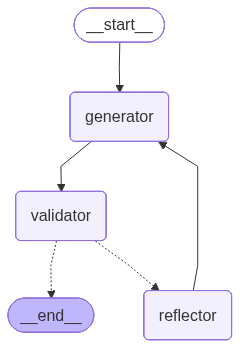

In [32]:
app

In [16]:
if os.path.exists("agent_memory.json"):
    os.remove("agent_memory.json")
    print("حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.")

حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.


In [33]:
def run_agent_test(task: str):
    initial_state = {
        "task": task,
        "code_attempt": "",
        "feedback": "",
        "attempt_count": 0,
        "solved": False
    }

    final_state = app.invoke(initial_state)

    print("\n====== نتیجه نهایی ======")
    print(f"Solved: {final_state.get('solved')}")
    print(f"Attempts: {final_state.get('attempt_count')}")
    print(f"Last feedback: {final_state.get('feedback')}")

    print("\n====== حافظه بلندمدت ======")
    lessons = memory_system.load_lessons()
    for i, lesson in enumerate(lessons, 1):
        print(f"{i}. {lesson}")

    return final_state

In [34]:
run_agent_test("یک لیست از اعداد صحیح بده که مجموعشان 100 شود و عدد 50 نداشته باشد")


--- تلاش 1 ---
کد خام مدل: numbers = [20, 30, 10, 40]
print(numbers)
موفقیت! کد صحیح و منطبق با قوانین است.

====== نتیجه نهایی ======
Solved: True
Attempts: 1
Last feedback: 

====== حافظه بلندمدت ======


{'task': 'یک لیست از اعداد صحیح بده که مجموعشان 100 شود و عدد 50 نداشته باشد',
 'code_attempt': 'numbers = [20, 30, 10, 40]\nprint(numbers)',
 'feedback': '',
 'attempt_count': 1,
 'solved': True}

In [35]:
run_agent_test("یک لیست از اعداد صحیح بده که مجموعشان 200 شود و عدد 50 نداشته باشد")


--- تلاش 1 ---
کد خام مدل: def find_numbers(target_sum):
    for i in range(1, target_sum):
        for j in range(i, target_sum):
            if i + j == target_sum and i != 50 and j != 50:
                return [i, j]

print(find_numbers(200))
درس جدید در حافظه بلند مدت ذخیره شد: استفاده از شیء ast در رشته‌های متنی که قرار است به عنوان کد مورد ارزیابی قرار گیرند، ممنوع است.

--- تلاش 2 ---
کد خام مدل: def generate_list(target_sum):
    result = []
    for i in range(1, target_sum):
        if i != 50:
            remaining_sum = target_sum - i
            if remaining_sum != 50:
                result.append(i)
                break
    for j in range(1, remaining_sum):
        if j != 50:
            result.append(j)
            remaining_sum -= j
            if remaining_sum == 0:
                break
            elif remaining_sum != 50:
                result.append(remaining_sum)
                break
    return result

print(generate_list(200))
درس جدید در حافظه بلند مدت ذخی

{'task': 'یک لیست از اعداد صحیح بده که مجموعشان 200 شود و عدد 50 نداشته باشد',
 'code_attempt': 'def generate_list():\n    result = []\n    for i in range(1, 50):\n        result.append(i)\n        if sum(result) >= 200:\n            break\n    if sum(result) < 200:\n        result.append(200 - sum(result))\n    return result\n\nprint(generate_list())',
 'feedback': 'مجموع اعداد 0 شد، اما باید 200 باشد.',
 'attempt_count': 4,
 'solved': False}

In [36]:
run_agent_test(
    "یک لیست بده که مجموعش 100 شود (می‌توانی از 50 استفاده کنی)")


--- تلاش 1 ---
کد خام مدل: numbers = [50, 50]
total = sum(numbers)
print(total)
درس جدید در حافظه بلند مدت ذخیره شد: استفاده از عدد 50 ممنوع است.

--- تلاش 2 ---
کد خام مدل: لیست = [20, 30, 10, 40]
مجموع = sum(لیست)
print(مجموع)
موفقیت! کد صحیح و منطبق با قوانین است.

====== نتیجه نهایی ======
Solved: True
Attempts: 2
Last feedback: 

====== حافظه بلندمدت ======
1. استفاده از شیء ast در رشته‌های متنی که قرار است به عنوان کد مورد ارزیابی قرار گیرند، ممنوع است.
2. از عدد صفر در محاسبات مجموع استفاده نکنید.
3. وقتی مجموع اعداد در کد به 0 می‌رسد، باید عدد یا اعداد دیگری جایگزین شود تا مجموع به مقدار مورد نظر برسد.
4. استفاده از عدد 50 ممنوع است.


{'task': 'یک لیست بده که مجموعش 100 شود (می\u200cتوانی از 50 استفاده کنی)',
 'code_attempt': 'لیست = [20, 30, 10, 40]\nمجموع = sum(لیست)\nprint(مجموع)',
 'feedback': '',
 'attempt_count': 2,
 'solved': True}

In [37]:
if os.path.exists("agent_memory.json"):
    os.remove("agent_memory.json")
    print("حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.")

حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.


In [50]:
run_agent_test(
    "یک لیست بده که مجموعش 100 شود (می‌توانی از 50 استفاده کنی)")


--- تلاش 1 ---
کد خام مدل: [50, 50]
درس جدید در حافظه بلند مدت ذخیره شد: استفاده از عدد 50 ممنوع است.

--- تلاش 2 ---
کد خام مدل: numbers = [20, 30, 10, 40]
total = sum(numbers)

if total < 100:
    numbers.append(100 - total)

print(numbers)
موفقیت! کد صحیح و منطبق با قوانین است.

====== نتیجه نهایی ======
Solved: True
Attempts: 2
Last feedback: 

====== حافظه بلندمدت ======
1. استفاده از عدد 50 ممنوع است.


{'task': 'یک لیست بده که مجموعش 100 شود (می\u200cتوانی از 50 استفاده کنی)',
 'code_attempt': 'numbers = [20, 30, 10, 40]\ntotal = sum(numbers)\n\nif total < 100:\n    numbers.append(100 - total)\n\nprint(numbers)',
 'feedback': '',
 'attempt_count': 2,
 'solved': True}

In [51]:
if os.path.exists("agent_memory.json"):
    os.remove("agent_memory.json")
    print("حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.")

حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.


In [63]:
result = run_agent_test("لیست اعداد با مجموع 100 بدون 50")

assert result["attempt_count"] <= 3
assert isinstance(result["solved"], bool)


--- تلاش 1 ---
کد خام مدل: def find_numbers(target_sum, exclude_num):
    result = []
    for i in range(1, target_sum):
        if i != exclude_num:
            for j in range(i, target_sum):
                if j != exclude_num:
                    for k in range(j, target_sum):
                        if k != exclude_num:
                            if i + j + k == target_sum:
                                result.append([i, j, k])
    return result

target_sum = 100
exclude_num = 50
print(find_numbers(target_sum, exclude_num))
درس جدید در حافظه بلند مدت ذخیره شد: استفاده از عددی که حاصل جمع آن با خودش منجر به عدد 0 شود، در محاسبه مجموع اعداد ممنوع است.

--- تلاش 2 ---
کد خام مدل: def find_numbers(total, excluded):
    def recursive_search(current_sum, current_list, start):
        if current_sum == total:
            return current_list
        for i in range(start, total - current_sum + 1):
            if i != excluded:
                new_list = recursive_search(current_sum + i,

AssertionError: 